# House_Price Prediction with PySpark

## Ertuğrul Sert 

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=986360be6d81201cc8dd90a2000cf112f0390a386561688837d3b24002f02a63
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql.types import * 
from pyspark.sql.functions import * 
from pyspark.ml.regression import LinearRegression 
from pyspark.ml.feature import VectorAssembler 

## Spark Session Starting and Uploading our Data
**[https://www.kaggle.com/datasets/camnugent/california-housing-prices](http://)**

In [3]:
#Spark Session Starting
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('House_Price Prediction with PySpark').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/31 13:40:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Upload data and Converting Dataframe
df_pyspark = spark.read.option('header','true').csv('/kaggle/input/california-housing-prices/housing.csv', inferSchema = True)
df_pyspark.show(20)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

## Row count and Describe using for the understand the Data

In [5]:
#Row Count
df_pyspark.count()

20640

In [6]:
#Trying to understand our Data with Describe.show()
df_pyspark.describe().show()

24/03/31 13:40:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

## Seeing Null Values at each Columns

In [7]:
#Eksik Değerleri Görmek için Döngü Yazıyoruz
for colu in df_pyspark.columns:
    miss = df_pyspark.filter(col(colu).isNull()).count()
    print(f"{colu} columns {miss} has missing value.")

longitude columns 0 has missing value.
latitude columns 0 has missing value.
housing_median_age columns 0 has missing value.
total_rooms columns 0 has missing value.
total_bedrooms columns 207 has missing value.
population columns 0 has missing value.
households columns 0 has missing value.
median_income columns 0 has missing value.
median_house_value columns 0 has missing value.
ocean_proximity columns 0 has missing value.


## Filling Null values with median

In [8]:
#Filling missing values with median at total_Bedrooms
mean_bedroom = df_pyspark.select(mean(df_pyspark['total_bedrooms'])).collect()[0][0]
df_pyspark = df_pyspark.na.fill({'total_bedrooms': mean_bedroom})
#controlling function has any missing value
df_pyspark.filter(col("total_bedrooms").isNull()).count()

0

## Outlier for total_rooms

In [9]:
#For Outlier 

# IQR calculation
Q1 = df_pyspark.approxQuantile("total_rooms", [0.25], 0)[0]
Q3 = df_pyspark.approxQuantile("total_rooms", [0.75], 0)[0]
IQR = Q3 - Q1

# Lower and Upper Limit Calculation
lower = Q1 - 1.5 * IQR
upper= Q3 + 1.5 * IQR

# Outlier Filtering with Filter function
df_pyspark = df_pyspark.filter((col("total_rooms") >= lit(lower)) & (col("total_rooms") <= lit(upper)))
df_pyspark.count()


19354

## Train and Test Data Split

In [10]:
#Data Split
splits = df_pyspark.randomSplit([0.8, 0.2]) 
train = splits[0] 
test = splits[1] 
train_rows = train.count() 
test_rows = test.count() 
print("Training Rows:", train_rows, " Testing Rows:", test_rows) 

Training Rows: 15483  Testing Rows: 3871


In [11]:
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.feature import VectorAssembler

# StringIndexer ile 'ocean_proximity' label to numeric
stringIndexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_idx")
stringIndexerModel = stringIndexer.fit(train)  # Ftting Traing
train_transformed = stringIndexerModel.transform(train)  # Transform

# VectorAssembler
assembler = VectorAssembler(
    inputCols=["ocean_proximity_idx", "longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"],
    outputCol="features"
)

# Training Taret is Median_Hause_value
training = assembler.transform(train_transformed).select(col("features"), (col("median_house_value").cast("Int").alias("label")))
training.show()



+--------------------+------+
|            features| label|
+--------------------+------+
|[2.0,-124.35,40.5...| 94600|
|[2.0,-124.27,40.6...| 79000|
|[2.0,-124.26,40.5...|111400|
|[2.0,-124.25,40.2...| 76100|
|[2.0,-124.23,40.5...|106700|
|[2.0,-124.23,40.8...| 50800|
|[2.0,-124.22,41.7...| 78300|
|[2.0,-124.21,41.7...| 66900|
|[2.0,-124.21,41.7...| 68400|
|[2.0,-124.19,40.7...| 90100|
|[2.0,-124.19,40.7...| 70000|
|[2.0,-124.19,41.7...| 74600|
|[2.0,-124.18,40.6...|107000|
|[2.0,-124.18,40.7...| 72200|
|[2.0,-124.18,40.7...| 67000|
|[2.0,-124.18,40.7...| 70200|
|[2.0,-124.18,40.7...| 70500|
|[2.0,-124.18,40.7...| 64600|
|[2.0,-124.17,40.6...| 86400|
|[2.0,-124.17,40.7...|116100|
+--------------------+------+
only showing top 20 rows



## I'm using an assembler again to index the labels in the test data and concatenate them into a single row.


In [12]:
# I'm using an assembler again to index the labels in the test data and concatenate them into a single row.
test_transformed = stringIndexerModel.transform(test)
testing = assembler.transform(test_transformed).select(
    "features", 
    (col("median_house_value").cast("Int").alias("trueLabel"))
)

testing.show()


+--------------------+---------+
|            features|trueLabel|
+--------------------+---------+
|[2.0,-124.3,41.8,...|    85800|
|[2.0,-124.3,41.84...|   103600|
|[2.0,-124.23,41.7...|    73200|
|[2.0,-124.21,40.7...|    58100|
|[2.0,-124.19,40.7...|    69000|
|[2.0,-124.17,40.7...|   128900|
|[2.0,-124.16,40.8...|    80500|
|[2.0,-124.16,41.7...|    69500|
|[2.0,-124.15,40.7...|   104200|
|[2.0,-124.15,40.8...|    74100|
|[2.0,-124.14,40.5...|    76800|
|[2.0,-124.14,40.7...|    99600|
|[2.0,-124.14,41.0...|   143400|
|[2.0,-124.13,40.7...|    83000|
|[2.0,-124.13,40.7...|    92800|
|[0.0,-124.11,40.5...|    74100|
|[2.0,-124.11,40.8...|    96100|
|[2.0,-124.09,40.8...|    82100|
|[2.0,-124.08,41.3...|    62800|
|[2.0,-123.92,41.5...|    71100|
+--------------------+---------+
only showing top 20 rows



# Linear Regression Machine Learning and Performance Metrics

In [13]:
#Linear Regresion Model
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="label")
lrModel = lr.fit(training)
lrPredictions = lrModel.transform(testing)

# Performans Metric
evaluator = RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction")
lrRmse = evaluator.evaluate(lrPredictions, {evaluator.metricName: "rmse"})
lrMae = evaluator.evaluate(lrPredictions, {evaluator.metricName: "mae"})
lrR2 = evaluator.evaluate(lrPredictions, {evaluator.metricName: "r2"})
print(f"Linear Regression - RMSE: {lrRmse}")
print(f"Linear Regression - MAE: {lrMae}")
print(f"Linear Regression - R^2: {lrR2}")


24/03/31 13:41:09 WARN Instrumentation: [64de1a87] regParam is zero, which might cause numerical instability and overfitting.
24/03/31 13:41:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/03/31 13:41:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression - RMSE: 69548.50344555354
Linear Regression - MAE: 51247.23254948833
Linear Regression - R^2: 0.6351038965873473


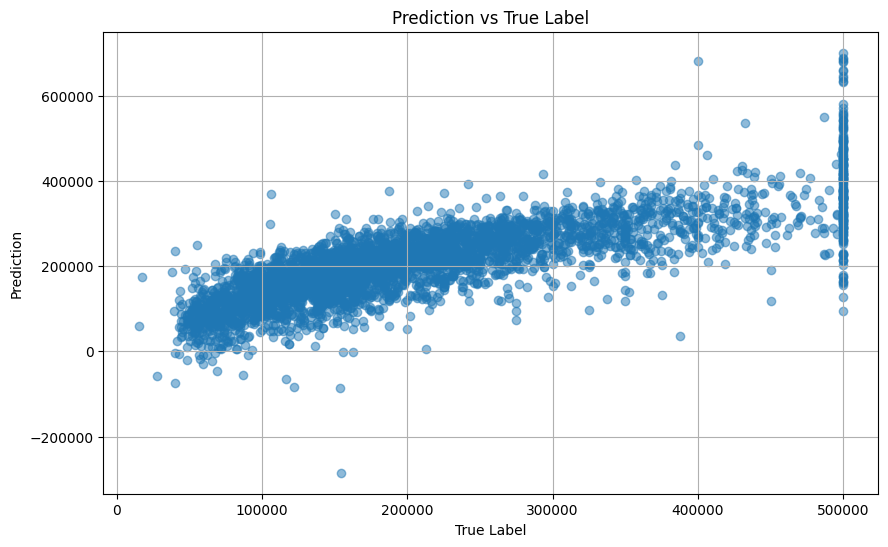

In [14]:
import matplotlib.pyplot as plt

# Pandas DataFrame
df = lrPredictions.select("prediction", "trueLabel").toPandas()
# Graph for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(df['trueLabel'], df['prediction'], alpha=0.5)
plt.xlabel('True Label')
plt.ylabel('Prediction')
plt.title('Prediction vs True Label')
plt.grid(True)
plt.show()


# RandomForestRegressor Machine Learning model and Performance Models

In [15]:
from pyspark.ml.regression import RandomForestRegressor

#Train ve Test for Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="label")
rfModel = rf.fit(training)
rfPredictions = rfModel.transform(testing)

#RMSE MAE R'2  
rfRmse = evaluator.evaluate(rfPredictions, {evaluator.metricName: "rmse"})
rfMae = evaluator.evaluate(rfPredictions, {evaluator.metricName: "mae"})
rfR2 = evaluator.evaluate(rfPredictions, {evaluator.metricName: "r2"})
print(f"Linear Regression - RMSE: {rfRmse}")
print(f"Linear Regression - MAE: {rfMae}")
print(f"Linear Regression - R^2: {rfR2}")

Linear Regression - RMSE: 70316.519965784
Linear Regression - MAE: 51775.26581328819
Linear Regression - R^2: 0.6270003836172882


# Grafik tahmin Random Forest için

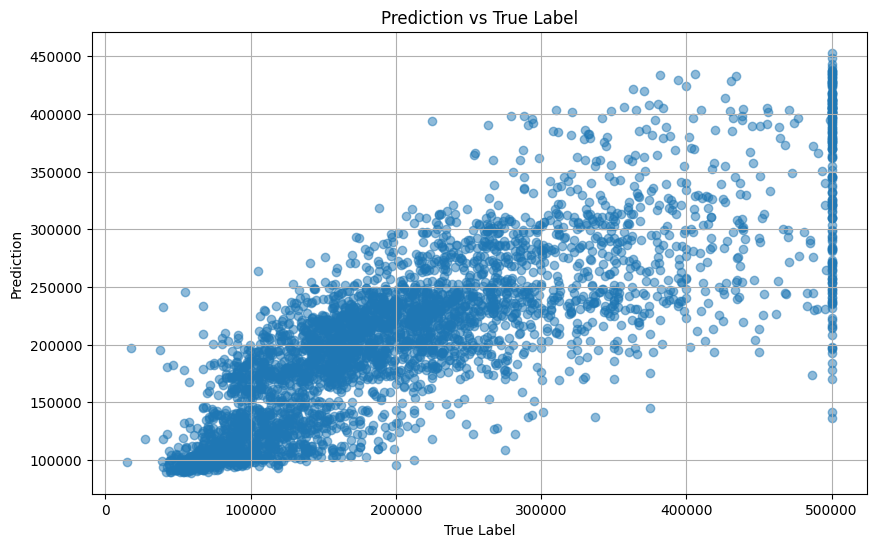

In [16]:
# Pandas DataFrame
df = rfPredictions.select("prediction", "trueLabel").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df['trueLabel'], df['prediction'], alpha=0.5)
plt.xlabel('True Label')
plt.ylabel('Prediction')
plt.title('Prediction vs True Label')
plt.grid(True)
plt.show()


# Gradient Boosting Machine Learning Model and Performance metrics

In [17]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100)
gbtModel = gbt.fit(training)
gbtPredictions = gbtModel.transform(testing)
gbtPredicted = gbtPredictions.select("features", "prediction", "trueLabel")

evaluator = RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction")

gbtRmse = evaluator.evaluate(gbtPredictions, {evaluator.metricName: "rmse"})
gbtMae = evaluator.evaluate(gbtPredictions, {evaluator.metricName: "mae"})
gbtR2 = evaluator.evaluate(gbtPredictions, {evaluator.metricName: "r2"})
print(f"Linear Regression - RMSE: {gbtRmse}")
print(f"Linear Regression - MAE: {gbtMae}")
print(f"Linear Regression - R^2: {gbtR2}")


Linear Regression - RMSE: 50340.84269561466
Linear Regression - MAE: 33944.053529492085
Linear Regression - R^2: 0.8088234544739241


# Gradient Boosting Tree Graph

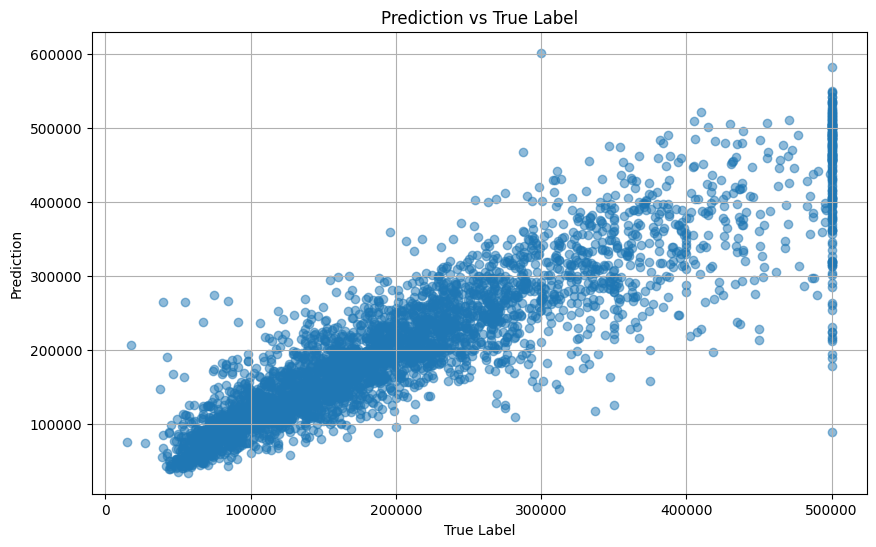

In [18]:
# Pandas DataFrame
df = gbtPredictions.select("prediction", "trueLabel").toPandas()
# Graph
plt.figure(figsize=(10, 6))
plt.scatter(df['trueLabel'], df['prediction'], alpha=0.5)
plt.xlabel('True Label')
plt.ylabel('Prediction')
plt.title('Prediction vs True Label')
plt.grid(True)
plt.show()
